## Assignment
Hi Rafael,

Hope you are well. The next step in our process at Innatera is a coding assignment with spiking neural networks. The task below is to be completed and returned to us by 13th May. 

Task
Implement a looped Synfire chain with 5 layers, each layer with 5 neurons. Layers are fully connected in a feed-forward fashion. The last layer is fully-connected back to the first layer completing the loop. Input is provided in the form of a single spike broadcasted to all neurons in the first layer with sufficient synaptic strength to make all 5 neurons spike once.
The implementation is to be done in Lava and in any other open-source simulator of your choice (this can be your own simulator as well). The language choice is up to you.

a) Plot the spike raster for at least 3 oscillations.
b) Compare differences, if any, between the two simulators.
c) Tune parameters of the network such that the 100th spike occurs at 100ms from the input spike.

Usage of open-source repositories is allowed as long as the functions used can be explained. Please send your files as an archive. A README file to allow us to run it should also be present.
Please do not hesitate to ask any questions for clarification if any. Also feel free to make any assumptions that you can reasonably justify. 


In [1]:
# Non custom imports
import numpy as np
from lava.proc.dense.process import Dense
from lava.proc.lif.process import LIF
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.ports import PyInPort, PyOutPort
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires
from lava.magma.core.model.py.model import PyLoihiProcessModel
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.ports.ports import InPort, OutPort

from lava.proc.dense.process import Dense
from lava.magma.core.model.sub.model import AbstractSubProcessModel

from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.decorator import implements

from lava.magma.core.run_configs import RunConfig, Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc.monitor.process import *
import matplotlib.pyplot as plt
import os

In [2]:
#Custom imports
dir_path = os.path.abspath('')
os.chdir(dir_path)
from utils_synfire import *

In this part of the assignment I have assumed that the models given in Lava are the only tools that I can employ to solve the problem. Thus, I have to employ the CuBa LIF model (I cannot create another) and I cannot employ delays since they are not implemented yet. 


Another assumption that I make in this part of the assignment is that the network must be stable. Therefore, since it is a CuBa LIF model, I have to compute the decays to make the system always spike at the same rate.

In order to make the system spike at the same rate with the given architecture

In [3]:
#Simulate for at least 100 seconds as specified
num_steps=101

#5 neurons per layer, 5 layers
layer_width=5
model_length=5

#Dimensions of the weights
dim=(layer_width,model_length)

#I assume this is the Voltage threshold 
vth_hi=[ 20*100*2 for k in range(layer_width)]

#I assume these are the weights 
weight_val=100
weights = weight_val*np.ones([model_length,layer_width,layer_width])

Since if there were no current decays then the system would not be stable, the inverse of the decay ($\tau$) is to be computed. It can be proven that the subthreshold dynamics that the CuBa LIF follows when there is no voltage decay are:

$U(t) = U_o e^{-\tau t}$

$V(t) = \sum_{t=0}^T U(t)$ 

(note that I know that tau is normally for the decay and not for the inverse of the decay)

Thus,

$V(t) = \sum_{t=0}^T U_o e^{-\tau t}$

In order to have a stable Synfire chain:
1) The current in each neuron must be enough to elicit the action potential, i.e. the voltage must reach the threshold. 

2) The current of each neuron must have a value close to 0 once the next oscillation arrives. Otherwise, the network would be unestable, since the current would increase in time which would accelerate the action potentials of each of the layers.

The first and second postulate imply that the previous equation must be rewritten as:

$V_{th} = \sum_{t=0}^T U_o e^{-\tau t}$

Since the problem specifies that the 100th spike must occur at the 100th time-step, the network will have 4 oscillations, taking 25 time-steps each. Therefore,

$V_{th} = \sum_{t=0}^{25} U_o e^{-\tau t}$

That equation is equivalent to

$ \frac{V_{th}}{ U_o} = \sum_{t=0}^{25} e^{-\tau t}$

Since this $\sum_{t=0}^{25} e^{-\tau t}$ is a geometric series, and assuming that $\sum_{t=0}^{25} e^{-\tau t} \approx \sum_{t=0}^{\infty} e^{-\tau t}$ :

$\sum_{t=0}^{25} e^{-\tau t} \approx \frac{1}{e^{\tau}-1} = \frac{V_{th}}{ U_o}$,

$\frac{U_{o}}{ V_{th}}+1 = e^{\tau}$

Meaning that the appropriate tau will be:

$ ln(\frac{U_{o}}{ V_{th}}+1) = \tau$


After knowing this, the only difficulty is to build and connect the layers appropriately and also setting the initial conditions without spike generator (there is not any in Lava).

In [4]:
#I assume that there is no bias current
bias=0

#Implementation of the derived equation
du = np.log((layer_width*weight_val)/vth_hi[0]+1)

#I assume there is no voltage decay
dv = 0

#Creation of the Dense-LIF layers
layers = [DenseLayer(shape=dim,weights=weights[i], bias=bias ,vth_hi=vth_hi[i],du=du,dv=dv) for i in range(model_length)]


monitors=[]

for i in range(model_length):
    
    #Connect the layers according to the specified architecture
    layers[i].s_out.connect(layers[(i+1)%model_length].s_in)
    mons=[]
    
    #Create monitors to probe voltage, current and spiking activity.
    mon_spike = Monitor()
    mon_v = Monitor()
    mon_u = Monitor()
    
    mon_v.probe(layers[i].v,num_steps)
    mon_u.probe(layers[i].u,num_steps)
    mon_spike.probe(layers[i].s_out,num_steps)
    
    mons.append(mon_spike)
    mons.append(mon_v)
    mons.append(mon_u)

    monitors.append(mons)


# Loihi1SimCfg is employed to run the simulation using CPU.
rcfg = Loihi1SimCfg()
initial_delay = 5
for t in range(num_steps):
    #run the model for each time-step
    layers[-1].run(condition=RunSteps(num_steps=1),run_cfg=rcfg)
    if t==0:
        
        #Setting these conditions in the first layer is equivalent to having a SpikeGenerator that excites all its neurons
        #layers[0].u.set(np.array([weight_val*5 for k in range(layer_width)]))
        layers[0].v.set(np.array([3*vth_hi[k]+1 for k in range(layer_width)]))
        
        #Here I am setting the appropriate current. Note that I need to devide by e^-du due to the implementation of Lava
        layers[0].u.set(np.array([(weight_val*5)/np.exp(-du) for k in range(layer_width)]))

        
        #Delays at Dense connections in Lava are still not implemented in its open-source version. Thus, I came up with
        #this initial conditions to implement some initial delays
        
        #Delays each of the remaining 4 layers by 6 time-steps.
        #It does this delay by substracting the voltage that corresponds to the 6 first time-steps to the voltage threshold.
        layers[1].v.set(np.array([ vth_hi[i]-np.sum([weight_val * layer_width * np.exp(-t*du) for t in range(initial_delay)]) for k in range(layer_width)]))
        layers[2].v.set(np.array([vth_hi[i]-np.sum([weight_val * layer_width * np.exp(-t*du) for t in range(initial_delay)]) for k in range(layer_width)]))
        layers[3].v.set(np.array([vth_hi[i]-np.sum([weight_val * layer_width * np.exp(-t*du) for t in range(initial_delay)])  for k in range(layer_width)]))
        layers[4].v.set(np.array([vth_hi[i]-np.sum([weight_val * layer_width * np.exp(-t*du) for t in range(initial_delay)]) for k in range(layer_width)]))
        #Note that by setting this initial conditions the last layer spikes one time-step before the first layer would. 
        #Then, there is one time-step of delay to propagate the spike,  eliciting more current in the first layer, which
        #which was absolutely necessary since right at that moment it is zero. All of this can be inspected in the plots below.
        

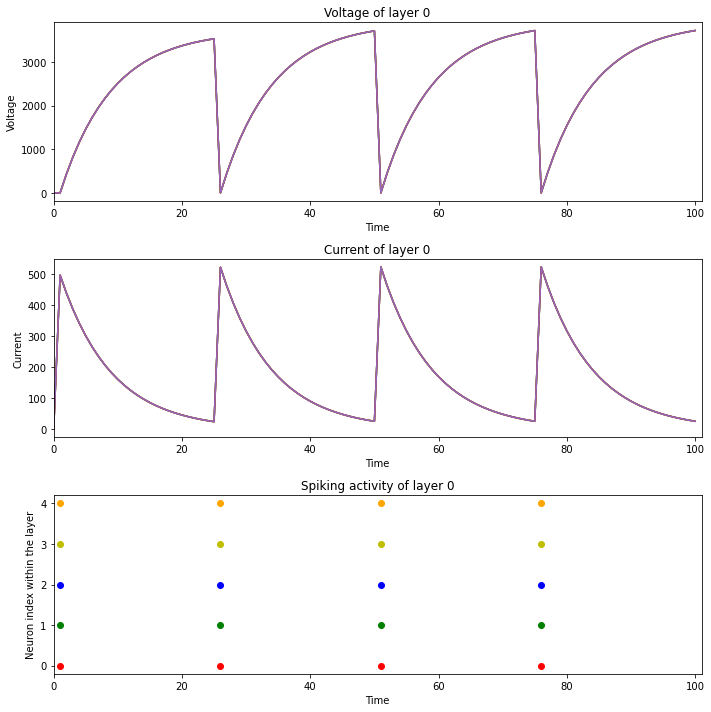

In [5]:
#plot_layer(0,monitors,lim=num_steps)
plot_layer(0,monitors,lim=num_steps,model_length=model_length)

Spike-timings of layer 0   [ 1 26 51 76]
Spike-timings of layer 1   [ 7 32 57 82]
Spike-timings of layer 2   [13 38 63 88]
Spike-timings of layer 3   [19 44 69 94]
Spike-timings of layer 4   [ 25  50  75 100]


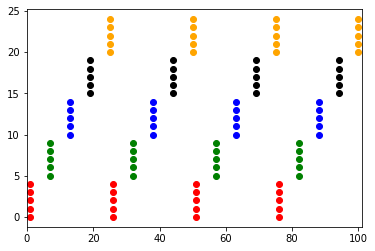

In [6]:
chain_raster_plot(monitors,model_length=model_length,num_steps=num_steps)

In [10]:
#Close resources
for k in range(model_length):
    layers[k].stop()

The given architecture has been implemented accordingly. There are 4 oscillations, evenly spaced (stable Synfire chain), and the 100th spike lies at the 100th time-step.